## Find PSF support

This is a short notebook to experiment with automatic detection of the size of the PSF support.
The background is that the input image should be padded by the size of the PSF in
order to avoid wrap-around artefacts. 
Looking at the dimensions of the PSF volume is not helpful if the main support of the
PSF is small and there is a lot of padding around.
Also, for PSFs derived from bead images there may be a low level of noise or background
intensity surrounding the PSF.

### Approach

* find maximum value of PSF volume
* threshold image at a fixed fraction of the maximum (e.g. 5%)
* determine bounding box.

In [3]:
import numpy as np
import tifffile 
from lls_dd.transform_helpers import get_projection_montage, plot_all


In [8]:
psf = tifffile.imread("c:/Users/Volker/Data/Experiment_testing_stacks/PSF_Processed/488/PSF_488.tif")
psf = np.squeeze(psf)

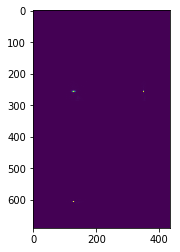

In [9]:
plot_all([get_projection_montage(psf)])

In [7]:
psf.shape

(1, 168, 1, 512, 256)

In [10]:
psf.max

<function ndarray.max>

In [15]:
maxpsf = psf.max()

In [16]:
maxpsf * 0.05

0.0004211425688554216

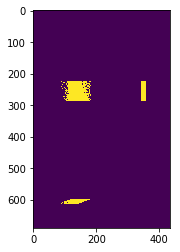

In [22]:
# plotting a really small percentage shows which areas have been padded
plot_all([get_projection_montage(psf > maxpsf * 0.001)])

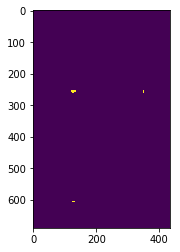

In [24]:
# Something like three percent seems to give a good approximation
plot_all([get_projection_montage(psf > maxpsf * 0.03)])

In [35]:
# A closer look 

a 1% threshold shows that there are some unwanted patches that we should probably remove from the PSF

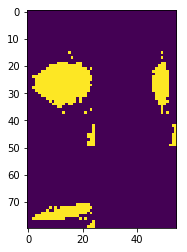

In [36]:
plot_all([get_projection_montage(psf[70:90, 230:280, 115:140] > maxpsf * 0.01)])

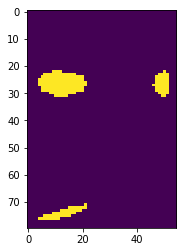

In [37]:
plot_all([get_projection_montage(psf[70:90, 230:280, 115:140] > maxpsf * 0.03)])

In [28]:
np.min(np.where(psf > maxpsf * 0.03), axis=1)

array([ 81, 252, 119], dtype=int64)

In [29]:
np.max(np.where(psf > maxpsf * 0.03), axis=1)

array([ 86, 261, 136], dtype=int64)

In [30]:
np.max(np.where(psf > maxpsf * 0.03), axis=1) - np.min(np.where(psf > maxpsf * 0.03), axis=1)

array([ 5,  9, 17], dtype=int64)

In [39]:
# actual size is +1 (otherwise we have a fencepost error)
np.max(np.where(psf > maxpsf * 0.03), axis=1) - np.min(np.where(psf > maxpsf * 0.03), axis=1) + np.array([1,1,1])

array([ 6, 10, 18], dtype=int64)

In [44]:
# put everything in a function

def find_PSF_support(psf_vol, threshold_percentage = 0.03):
    """find the size of the PSF as the bounding box of the area that is above a fraction of the max intensity"""
    maxval = psf_vol.max()
    mask = psf_vol > maxval * threshold_percentage
    locations = np.where(mask)
    tmp = np.max(locations, axis=1) - np.min(locations, axis=1)
    support_size = tmp + np.array([1, 1, 1]) # add one to avoid fencepost error
    return support_size

In [45]:
find_PSF_support(psf)

array([ 6, 10, 18], dtype=int64)

In [46]:
support_sizes = support_sizes = [find_PSF_support(p) for p in (psf, psf, psf)]

In [47]:
support_sizes

[array([ 6, 10, 18], dtype=int64),
 array([ 6, 10, 18], dtype=int64),
 array([ 6, 10, 18], dtype=int64)]

In [49]:
np.max(np.array(support_sizes), axis=0)

array([ 6, 10, 18], dtype=int64)